# Preprocessing H3 Data

Now that we have hexagons covering London, the next step is to link the census data with each hexagon. Here's the methodology:

1. Compute the **centroid** of each census tract/block group.
2. Assign census data (e.g., **median household income**) to these centroids.
3. Use **kriging interpolation** to generate a continuous surface.
4. Overlay an **H3 hexagonal grid** onto the interpolated surface.
5. Compute **average income per hexagon**.

(Source: https://www.cbre-ea.com/publications/ea-insights/ea-insights/2025/02/26/converting-census-data-to-different-geographic-areas)

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import h3
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import requests

### Step 1: Load Census Data & Compute Centroids

In [4]:
census_df = pd.read_csv('..\Datasets\socioeconomic_data.csv')
lsoa_gdf = gpd.read_file("map.geojson") # LSOA boundaries

census_df = census_df.rename(columns={"LSOA11CD": "lsoa21cd"})

census_gdf = lsoa_gdf.merge(census_df, on="lsoa21cd")

# Compute centroids of each LSOA area
census_gdf["centroid"] = census_gdf.geometry.centroid

# Extract coordinates and attributes
census_gdf["lon"] = census_gdf.centroid.x
census_gdf["lat"] = census_gdf.centroid.y

# Select relevant data
data_points = census_gdf[["lon", "lat", "IMD score","population"]].dropna()
print(data_points.head())

        lon        lat  IMD score  population
0  0.080695  51.543080       30.7      1753.0
1  0.119939  51.536544       29.8      1935.0
2  0.082312  51.534288       36.9      1021.0
3  0.125836  51.549619       41.0      1586.0
4  0.128351  51.553509       34.4      1956.0


C:\Users\beam_\AppData\Local\Temp\ipykernel_32108\3296676055.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_gdf["centroid"] = census_gdf.geometry.centroid
C:\Users\beam_\AppData\Local\Temp\ipykernel_32108\3296676055.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_gdf["lon"] = census_gdf.centroid.x
C:\Users\beam_\AppData\Local\Temp\ipykernel_32108\3296676055.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_gdf["lat"] = census_gdf.centroid.y


In [5]:
# Define grid for interpolation
grid_x = np.linspace(census_gdf["lon"].min(), census_gdf["lon"].max(), 200)
grid_y = np.linspace(census_gdf["lat"].min(), census_gdf["lat"].max(), 200)

# Create a 2D grid from grid_x and grid_y
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Perform Kriging interpolation for IMD score
OK_imd = OrdinaryKriging(data_points["lon"], data_points["lat"], data_points["IMD score"], variogram_model="spherical")
z_imd, _ = OK_imd.execute("grid", grid_x, grid_y)

# Perform Kriging interpolation for population
OK_population = OrdinaryKriging(data_points["lon"], data_points["lat"], data_points["population"], variogram_model="spherical")
z_population, _ = OK_population.execute("grid", grid_x, grid_y)

# Convert interpolation results to DataFrame
interpolated_df = pd.DataFrame({
    "lon": grid_xx.flatten(),
    "lat": grid_yy.flatten(),
    "IMD score": z_imd.flatten(),
    "population": z_population.flatten()
})
print(interpolated_df.head())

        lon        lat  IMD score   population
0 -0.489777  51.296409  19.193586  1800.786435
1 -0.485802  51.296409  19.193586  1800.786435
2 -0.481827  51.296409  19.193586  1800.786435
3 -0.477852  51.296409  19.193586  1800.786435
4 -0.473877  51.296409  19.193586  1800.786435


In [6]:
# Define hex resolution
hex_resolution = 9  # Adjust as needed

# Assign each interpolated point to an H3 hexagon
interpolated_df["h3_index"] = interpolated_df.apply(lambda row: h3.latlng_to_cell(row["lat"], row["lon"], hex_resolution), axis=1)

# Compute average IMD score and total population per hexagon
hex_aggregated = interpolated_df.groupby("h3_index").agg(
    avg_imd_score=("IMD score", "mean"),
    total_population=("population", "sum")  # Use "mean" if you want the average population instead
).reset_index()

# Convert hexagons to GeoJSON format
hex_aggregated["geometry"] = hex_aggregated["h3_index"].apply(lambda h: Polygon(h3.cell_to_boundary(h)))
hex_gdf = gpd.GeoDataFrame(hex_aggregated, geometry="geometry")

print(hex_gdf.head())

          h3_index  avg_imd_score  total_population  \
0  89194a8b4d3ffff      19.148057       1800.786435   
1  89194a8b4dbffff      19.123963       1800.786435   
2  89194a98203ffff      19.193586       3601.572870   
3  89194a98207ffff      19.193586       1800.786435   
4  89194a9820bffff      19.193586       3601.572870   

                                            geometry  
0  POLYGON ((51.29727 0.21886, 51.29629 0.21678, ...  
1  POLYGON ((51.29706 0.21428, 51.29609 0.21219, ...  
2  POLYGON ((51.34538 0.28846, 51.34441 0.28637, ...  
3  POLYGON ((51.34286 0.29138, 51.34189 0.2893, 5...  
4  POLYGON ((51.34518 0.28387, 51.34421 0.28178, ...  


In [7]:
print(hex_gdf.columns)
hex_gdf.to_file("hex_dataset.geojson", driver="GeoJSON")

Index(['h3_index', 'avg_imd_score', 'total_population', 'geometry'], dtype='object')


c:\Users\beam_\anaconda3\lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


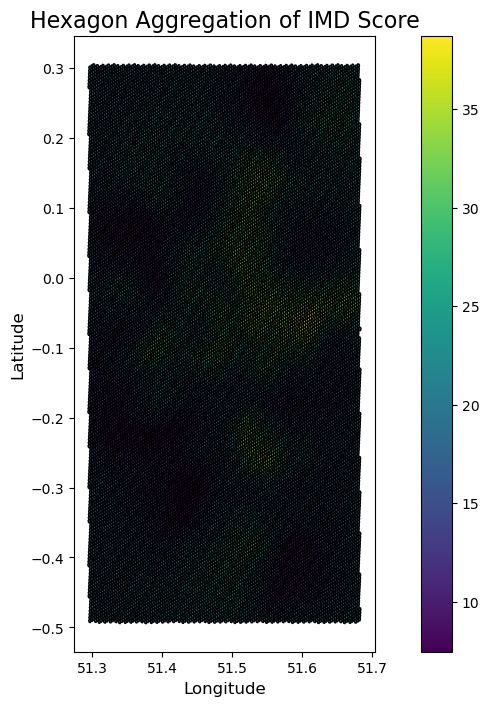

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot the hexagons with color representing avg_imd_score
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
hex_gdf.plot(
    column="avg_imd_score",  # Column to color by
    cmap="viridis",         # Colormap
    legend=True,            # Add a legend
    ax=ax,                  # Axes to plot on
    edgecolor="k"           # Hexagon borders
)

# Add title and labels
ax.set_title("Hexagon Aggregation of IMD Score", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

## Existing Stations to GEOJSON

In [9]:
# Fetch data from TfL API
url = "https://api.tfl.gov.uk/BikePoint"
response = requests.get(url).json()

# Extract coordinates and names of bike points
coordinates = [(float(point['lon']), float(point['lat'])) for point in response]  # Correct order [lon, lat]
names = [point['commonName'] for point in response]

# Create a DataFrame for the bike stations
bike_stations_df = pd.DataFrame({
    "name": names,
    "lon": [coord[0] for coord in coordinates],
    "lat": [coord[1] for coord in coordinates]
})

# Assign each bike station to an H3 hexagon
hex_resolution = 9  # Adjust resolution as needed
bike_stations_df["h3_index"] = bike_stations_df.apply(
    lambda row: h3.latlng_to_cell(row["lat"], row["lon"], hex_resolution), axis=1
)

# Count the number of stations in each hexagon
hex_counts = bike_stations_df.groupby("h3_index").size().reset_index(name="station_count")

# Merge the counts back into the bike stations DataFrame
bike_stations_df = bike_stations_df.merge(hex_counts, on="h3_index")

# Convert to a GeoDataFrame
bike_stations_gdf = gpd.GeoDataFrame(
    bike_stations_df,
    geometry=gpd.points_from_xy(bike_stations_df["lon"], bike_stations_df["lat"]),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Save to a GeoJSON file
bike_stations_gdf.to_file("existing_bike_stations.geojson", driver="GeoJSON")

print("GeoJSON file 'existing_bike_stations.geojson' has been created.")

GeoJSON file 'existing_bike_stations.geojson' has been created.


## Check if the dataframe we made make sense.

In [10]:
# Check for rows with population of 0
zero_population_rows = hex_gdf[hex_gdf["total_population"] == 0]

# Print the rows with population of 0, if any
if not zero_population_rows.empty:
    print("Rows with population of 0:")
    print(zero_population_rows)
else:
    print("No rows with population of 0.")

No rows with population of 0.
